The first step, let's import all the libraries

In [1]:
!pip install autofd &> /dev/null
!pip install jax_xc &> /dev/null

In [17]:
import sys
sys.path.append("../")
import jax
from jax import lax
import numpy as np
import jax.numpy as jnp
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from ase.dft.kpoints import monkhorst_pack
from jrystal import crystal, energy, wave, occupation
from jrystal._src.grid import g_vectors, r_vectors, half_frequency_mask
from jrystal._src.bloch import bloch_wave
jax.config.update("jax_enable_x64", True)

We then create a crystal structure. The crystal structure looks like something below, it is made of repeatively tiled cells (We only show a 3x3 tile in 2D space, in reality, we consider 3D cells tiled infinitely). In each cell, there are atoms. Electrons of the atoms are described with wave functions in the 3D space.

![](./crystal.svg)

The variables that we need for calculating the electron wave functions include 
- The geometry of the unit cell, unit cells are parallelpipeds, they can be described by the three basis vectors.
- The atoms' positions within the unit cell, and the type of the atoms.

In [3]:
a = 3.5667  # angstrom
cell_vectors = np.array(
  [(0, a / 2, a / 2), (a / 2, 0, a / 2), (a / 2, a / 2, 0)]
)
symbols = 'C2'
positions = np.array([(0, 0, 0), (a / 2, a / 2, a / 2)])
diamond = crystal.Crystal(
  symbols=symbols,
  positions=positions,
  cell_vectors=cell_vectors,
)

## Grid Sampling and Fourier Transformation

Without going into physics, let's state something general about periodic functions living in the cells.
If we sample the value of a periodic functions $f$ on the red grid in the real space unit cell as shown below, we can perform Discrete Fourier Transformation to get the value of $F$ at the corresponding grid in the reciprocal (frequency) space.

Let

$$\boldsymbol{r} = \frac{n_1}{N_1}\boldsymbol{a_1} + \frac{n_2}{N_2}\boldsymbol{a_2} + \frac{n_3}{N_3}\boldsymbol{a_3}$$ 

$N_1, N_2, N_3$ are the number of points sampled along each of the cell vector, and $n_i\in[0 .. N_i)$. This grid of points are illustrated as the red dots in the real space.

The corresponding grid in the reciprocal space are

$$\boldsymbol{G} = {n_1}\boldsymbol{b_1} + {n_2}\boldsymbol{b_2} + {n_3}\boldsymbol{b_3}$$

Where $b_3=2\pi (\boldsymbol{a_1}\times \boldsymbol{a_2})$. They are illustrated as the red dots in the reciprocal space. They represent the frequency components that we're able to capture about the function $f$ with the real space grid that we sample. If we sample more densely in the real space, correspondingly we get a more dense grid in the reciprocal space too.

Correspondingly, we can also sample $F$ within the reciprocal unit cell, as shown in green dots. If we perform inverse Discrete Fourier Transformation, we get the value of $f$ at the green grid in the real space. If the green dots are more dense, it gives us information of a larger region in the real space.

![](./grids.svg)



## Electron wave functions
Given the above crystal structure, we would like to calculate the electron wave function. According to Bloch theorem, the wave functions of electrons can be parameterized as the following form. 

$$\psi_{ik}=e^{-i\boldsymbol{k}\boldsymbol{r}}\sum_G c_{ikG} e^{i\boldsymbol{G}\boldsymbol{r}}$$

The $G$ are the red grid point in the reciprocal space. More $G$ points means denser red dots in the real space, therefore a higher resolution (higher approximation capability) within the real space unit cell.

The $k$ are the green grid points in the reciprocal space. As seen from the figure, more k points means we cover more cells in the real space. Since there are electrons in each cells, the more cells we cover, the more electrons we need to describe. Therefore the electron wave function $\psi_{ik}$ is indexed by $i$ and $k$, where $k$ is the index of the cell and $i$ is the index of the electron wthin the cell.

The $c$ are flexible parameters that can be learned to minimize the energy of the entire system.

In [4]:
k_grid_sizes = [1, 1, 1]  # for simplicity we sample just one k point
g_grid_sizes = [10, 10, 10]  # we sample 10 x 10 x 10 G grid.
num_k = np.prod(k_grid_sizes)
num_g = np.prod(g_grid_sizes)

# we use the following APIs to sample the grid of k and G points.
k_vector_grid = monkhorst_pack(k_grid_sizes)
g_vector_grid = g_vectors(cell_vectors, g_grid_sizes)
# the number of electrons per unit cell.
num_electrons = diamond.num_electrons
# each electron has two spins, up/down.
num_spins = 2

def volume(cell_vectors):
  return jnp.linalg.det(cell_vectors)

vol = volume(cell_vectors)

## TODO: we need an intuitive intro to occupation, which is difficult!

In [5]:
# TODO Occupation

def normalize(raw_occ):
    raw_occ += (num_electrons - jnp.sum(raw_occ.flatten())) / np.prod(raw_occ.shape)
    return raw_occ

def clip(raw_occ):
    return jnp.clip(raw_occ, a_min=0, a_max=1 / num_k)

def constrain_occ(raw_occ):
    cond_fn = lambda x: jnp.logical_not(jnp.array_equal(clip(x), x))
    body_fn = lambda x: normalize(clip(x))
    return lax.while_loop(cond_fn, body_fn, raw_occ)


In [49]:
# Now let's build a wave function that depends on the parameter
from jrystal import wave

def electron_wave_function(parameter, r, force_fft=False):
  # jrystal provide the bloch_wave api to construct a bloch wave function
  # given the G points, k points.
  psi = bloch_wave(cell_vectors, parameter, k_vector_grid)
  # Notice that the bloch wave is not normalized on the unit cell, 
  # but we would like to normalize the electron wave function on the unit cell.
  # if a batch of r of shape (batch..., 3) is passed to bloch_wave
  # this function will return the batch dimensions at the last
  # aka (num_spins, num_electrons, num_k_points, batch...).
  return psi(r, force_fft=force_fft) / jnp.sqrt(vol)

# We need to verify that when we supply a orthonormal set of parameters
# the resulting wave functions are orthonormal.

# 1. create 32 random orthonormal parameter
random_param, _ = jnp.linalg.qr(
  jax.random.normal(
    jax.random.PRNGKey(0),
    (np.prod(g_grid_sizes), 32),
  ),
  mode="reduced",
)
random_param = jnp.reshape(random_param.T, (32, *g_grid_sizes))

# 2. we compute their overlap
def integrate_within_cell(fn):
  r_vector_grid = r_vectors(cell_vectors, g_grid_sizes)
  out = fn(r_vector_grid)
  return jnp.mean(out) * vol

def overlap_ab(param_a, param_b):
  return integrate_within_cell(lambda r: jnp.real(
    jnp.conj(electron_wave_function(param_a, r, force_fft=True)) *
    electron_wave_function(param_b, r, force_fft=True)
  ))

def overlap(param):
  return jax.vmap(
    jax.vmap(
      overlap_ab,
      in_axes=(None, 0),
    ),
    in_axes=(0, None),
  )(param, param)

# <psi|psi>, we expect all of them are one.
psi_l2_norm = overlap(random_param)
target = jnp.eye(psi_l2_norm.shape[0])
print("Max error is: ", jnp.abs(psi_l2_norm - target).max())


Max error is:  9.499490549735867e-08


In [7]:
# With occupation and wave function, we can create a density function

def density(param, occ, r, force_fft=False):
  psi = electron_wave_function(param, r, force_fft=force_fft)
  dens = jnp.real(jnp.conj(psi) * psi)
  return jnp.einsum("ski...,ski->s...", dens, occ)
    

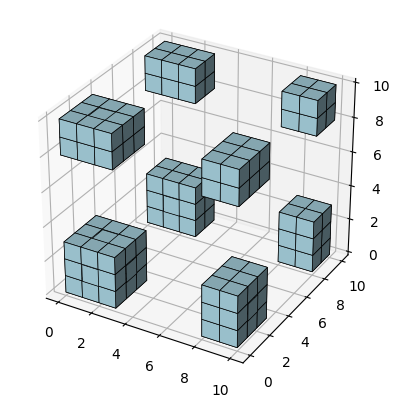

In [34]:
# The parameter c we pass to the wave function needs some constraints though
# It has the following shape
c_shape = (num_spins, num_k, num_electrons, *g_grid_sizes)

# However, we only keep half of the frequency components in c according to the G grid.
# The reason is that, the electron density is the sum of square of the wave functions
# Therefore, if the maximum frequency component in a wave function is M, the maximum for
# density function will be 2*M, that means if we include all the frequency component
# into the wave function, we'll have to use twice as dense a grid to sample the density
# function.
# Therefore, we only use half of the components for the wave function.
# We provide a convenient function to get the mask that indicates which frequency components
# are kept.
mask = half_frequency_mask(g_grid_sizes)
mask_size = int(jnp.sum(mask))

# show this mask
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
colors = np.empty(g_grid_sizes, dtype=object)
colors[mask] = "lightblue"
ax.voxels(mask, facecolors=colors, linewidth=0.5, edgecolor="black")
ax.set_aspect('equal')


The above mask may seem unintuitive, this is because in FFT the frequency domain is reorganized from
`[-3, -2, -1, 0, 1, 2, 3]` into `[0, 1, 2, 3, -3, -2, -1]`,
causing the lower frequency half to be on the sides, in 3D they are at the corners.


In [8]:
# We also want the < c[s, k, i], c[s, k, i'] > = delta_{i,i'}
# any wave function has an unit l2 norm.
# any two electron wave functions with same s and k needs to be orthogonal to each other.
# Translating to the parameter, we request c to be orthonormal,
# we make this happen via QR transform, now we have a legit parameter c.

# For convenience, we can create a function like below to transform our raw parameter
# to constrained parameter.
# If we get a raw_param of shape (num_spins, num_k, num_electrons, *g_grid_sizes)
def constrain_param_1(raw_param):
  # keep only the masked region
  masked_param = raw_param[..., mask]
  # orthogonalize the masked region
  masked_orthogonal_param = jnp.swapaxes(
    jnp.linalg.qr(
      jnp.swapaxes(masked_parameter, -1, -2), mode="reduced"
    )[0], 
    -1, 
    -2,
  )
  # set the unmasked region to zero, mask region to the orthogonalized
  # values.
  return jnp.zeros_like(raw_param, dtype=jnp.complex128).at[..., mask].set(
    masked_orthogonal_param,
  )

# We can further simplify because raw_param has many zero entries
# where raw_param has shape (num_spins, num_k, mask_size, num_electrons)
# We save a swapaxes and a cropping in this way.
raw_param_shape = (num_spins, num_k, mask_size, num_electrons)

def constrain_param(raw_param):
  raw_param = jnp.swapaxes(
    jnp.linalg.qr(raw_param, mode="reduced")[0], 
    -1, -2,
  )
  return jnp.zeros(c_shape, dtype=jnp.complex128).at[..., mask].set(
    raw_param,
  )


Let's now test whether under this constrain the wave function still satisfy all desired properties.
Aka, when an unconstrained parameter is constrained, the resulting wave functions are orthonormal.

In [52]:
# 1. we need the waves with same k but different i to be orthogonal to each other
raw_param = jax.random.normal(
  key=jax.random.PRNGKey(0),
  shape=raw_param_shape,
  dtype=jnp.complex128,
) * 0.01
param = constrain_param(raw_param)  # (num_spins, num_k, num_electrons, *g_grid_sizes)
param = jnp.reshape(param, (-1, *param.shape[2:]))

out = jax.vmap(overlap)(param)
target = jnp.eye(out.shape[-1])
print("Max error is: ", jnp.abs(out - target).max())


(2, 12, 10, 10, 10)
Max error is:  9.499490549735867e-08


In a larger scope, we're building the following computational graph

`nonzero_param` $\overset{\text{orthogonalize}}{\longrightarrow}$ `nonzero_orthogonal_param` $\overset{\text{embed in the grid}}{\longrightarrow}$ `parameter` $\longrightarrow$ `wave_function` $\longrightarrow$ `energy`

What we need is the optimal wave function that minimizes the energy, however, we perform the minimization in the space of the raw parameter, we compute the gradient of the energy function with respect to the `nonzero_param`, so as to minimize the energy.

In [9]:
# Let's now compute the energy,
import autofd
import jax_xc
from jrystal import energy
from jaxtyping import Float64, Array

def diamond_energy(raw_param, raw_occ):
  param = constrain_param(raw_param)
  occ = constrain_occ(raw_occ)
  r_vector_grid = r_vectors(cell_vectors, g_grid_sizes)
  # because we pass the r_vector_grid, which can be accelerated by fft
  density_grid = density(param, occ, r_vector_grid, force_fft=True)
  assert density_grid.shape == (num_spins, *g_grid_sizes)
  reciprocal_density_grid = jnp.fft.fftn(density_grid.sum(0), axes=(-3, -2, -1))
    
  kinetic = energy.kinetic(
    g_vector_grid,
    k_vector_grid,
    param,
  )
  hartree = energy.hartree(
    reciprocal_density_grid,
    g_vector_grid,
    vol,
  )
  external = energy.external(
    reciprocal_density_grid,
    diamond.positions,
    diamond.charges,
    g_vector_grid,
    vol,
  )

  r = r_vector_grid.reshape((-1, 3))

  @autofd.function
  def dens(r: Float64[Array, "3"]) -> Float64[Array, "2"]:
    return density(param, occ, r, force_fft=True)

  with jax.ensure_compile_time_eval():
    epsilon_xc = jax_xc.experimental.gga_x_pbe(dens)
    
  xc_grid = jax.vmap(
    lambda r: epsilon_xc(r) * dens(r).sum(),
    in_axes=0,
    out_axes=-1,
  )(r)
  exc = xc_grid.sum() / vol / num_g    
  return (kinetic, hartree, external, exc)

raw_param = jax.random.normal(
  key=jax.random.PRNGKey(0),
  shape=raw_param_shape,
  dtype=jnp.complex128,
) * 0.01

raw_occ = jax.random.normal(
  key=jax.random.PRNGKey(1), 
  shape=c_shape[:3]
) * 0.01

jax.jit(diamond_energy)(raw_param, raw_occ)




(Array([[[26.07609476, 29.91316694, 27.91588903, 26.14108661,
          27.38672038, 26.66692524, 28.43235539, 28.1966382 ,
          25.79647596, 26.84617272, 28.01971   , 29.6083565 ]],
 
        [[29.86926294, 26.55522952, 28.68060309, 28.48468955,
          29.83610364, 26.34964047, 28.7817872 , 25.87229218,
          24.88921473, 27.22891689, 27.34672251, 26.78638268]]],      dtype=float64),
 Array(0.04243998, dtype=float64),
 Array(-0.19851474, dtype=float64),
 Array(-0.07413534, dtype=float64))